## First step to clean the dataset:

- Select only English movies
- Select onlu full-length feature (movies of more than one hour long)
- Remove movies for which we don't have the title

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import numpy as np
import string
import json

In [131]:
character_metadata = pd.read_csv('Data/character.metadata.tsv', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'Freebase_movie_ID',
                                                                              'Movie_release_date',
                                                                              'Character_name',
                                                                              'Actor_date_of_birth',
                                                                              'Actor_gender',
                                                                              'Actor_height',
                                                                              'Actor_ethnicity',
                                                                              'Actor_name',
                                                                              'Actor_age_at_movie_release',
                                                                              'Freebase_character/actor_map_ID',
                                                                              'Freebase_character_ID',
                                                                              'Freebase_actor_ID'])

movie_metadata = pd.read_csv('Data/movie.metadata.tsv', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'Freebase_movie_ID',
                                                                              'Movie_name',
                                                                              'Movie_release_date',
                                                                              'Movie_box_office_revenue',
                                                                              'Movie_runtime',
                                                                              'Movie_languages',
                                                                              'Movie_countries',
                                                                              'Movie_genres'])

plot_summaries = pd.read_csv('Data/plot_summaries.txt', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'summary'])

In [132]:
#Copy of movie_metadata dataset
movie_metadata_readable = movie_metadata.copy(deep= True)

# Make the column Movie_languages, Movie_countries and Movie_genres more readable (i.e change as list)

def readable(column):
    pd.set_option('mode.chained_assignment', None) #remove warning
    for i in column.index:
        d=json.loads(column[i]) #change set of each row from the colomn to dict
        column[i]=list(d.values()) #change the dict into list

readable(movie_metadata_readable['Movie_languages'])
readable(movie_metadata_readable['Movie_countries'])
readable(movie_metadata_readable['Movie_genres'])

movie_metadata_readable.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


In [169]:
#Filtering of movie_metada, keeping only full-length features movies (more than 60 minutes long) and that have a Title in the database.
movie_metadata_filtered = movie_metadata_readable.copy(deep=True)
print(f"Number of movies in the database before the first cleaning step: {movie_metadata_filtered['Movie_release_date'].size}.")


movie_metadata_filtered.dropna(subset=['Movie_name'],inplace=True)

movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered.Movie_runtime >= 60]


#Cleaning of the Movie_release_date column, to keep only the year of release
movie_metadata_filtered.dropna(subset=['Movie_release_date'], inplace = True)
movie_metadata_filtered["Movie_release_date"] = movie_metadata_filtered['Movie_release_date'].apply(lambda x : str(x)[:4]).apply(lambda x : int(x))


print(f"Number of movies in the database after this first cleaning step: {movie_metadata_filtered['Movie_release_date'].size}.")

Number of movies in the database before the first cleaning step: 81741.
Number of movies in the database after this first cleaning step: 52286.


# Language filtering
Because we want to do NLP analysis of the title, we want to filter the dataset to keep mainly english movies, as the NLP packages are mostly developed for english. To do this easily we may want to only select movies that have English as main language as they should also have an English title.

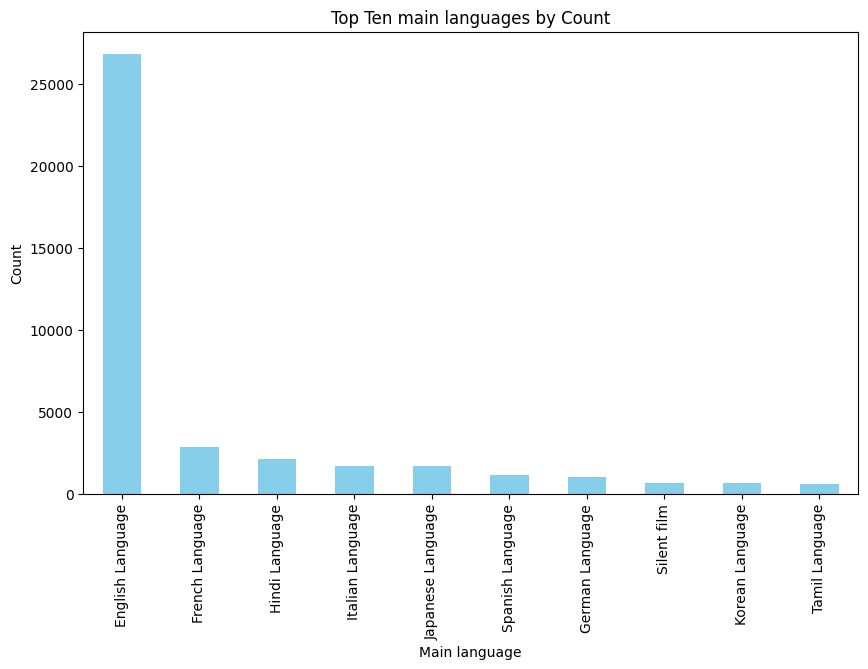

In [170]:
#Movie distribution per languages

movie_metadata_filtered['Movie_main_language'] = movie_metadata_filtered.Movie_languages.str[0]
movie_metadata_filtered['Movie_main_language'] = movie_metadata_filtered.Movie_main_language.astype('category')

# Create a DataFrame with feature counts
main_languages = movie_metadata_filtered['Movie_main_language'].value_counts()

# Select the top ten features
top_ten_main_languages = main_languages.head(10)

# Plot the bar plot
plt.figure(figsize=(10, 6))
top_ten_main_languages.plot(kind='bar', color='skyblue')
plt.title('Top Ten main languages by Count')
plt.xlabel('Main language')
plt.ylabel('Count')
plt.show()


#plt.figure(figsize=(30,10))
##plt.rc('axes', unicode_minus=False)
#ax = sns.histplot(movie_metadata_filtered,x='Movie_main_language',stat='count',color='orange')
#plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
#plt.gcf().subplots_adjust(bottom=0.15)


#The warning messages are due to some errors because of the font used which is not able to print foreign characters (Chinese or Arab characters for example)

#The most used language is the english. It should not be a problem to only keep movies with english as main language.

The main language of most movies is English, so keeping only these movies should not alter too much the whole database.

In [171]:
#Create dataset with filtered language:  english as first language

movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered.Movie_main_language=="English Language"] #English Language as First Language

print(f"Number of movies in the database after the language filtering: {movie_metadata_filtered['Movie_release_date'].size}.")

Number of movies in the database after the language filtering: 26855.


# Temporal distribution

Let's explore our data. One first thing to look at is the temporal distribution of movies. When where movies released and how did it changed with time?

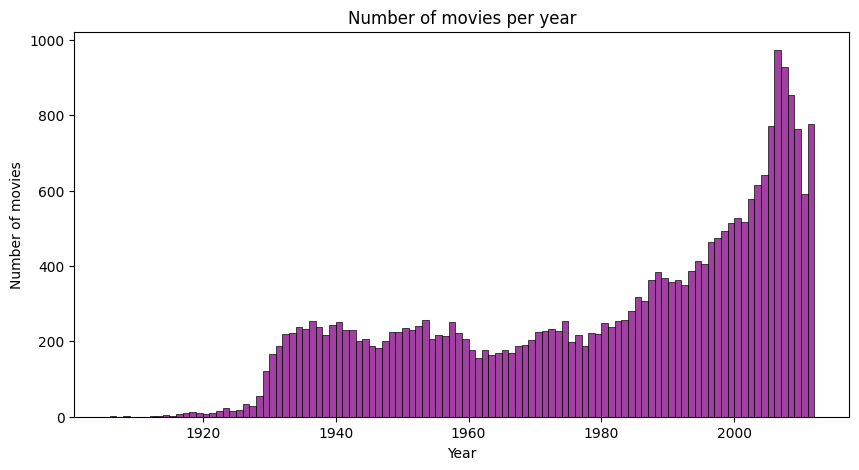

In [192]:
#Number of movies per year
plt.figure(figsize=(10,5))
ax = sns.histplot(movie_metadata_filtered,x='Movie_release_date',stat='count',color="purple",bins = 106).set(title="Number of movies per year",xlabel="Year",ylabel="Number of movies")

Our dataset was extracted in 2012. Thus, the movies released after 2012 miss a lot of information. Let's see if some movies have a release date after 2012

In [173]:
movie_metadata_filtered[movie_metadata_filtered.Movie_release_date > 2012]

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_main_language
2942,29097142,/m/0dlk_qn,Movie 43,2013,NaN,175.0,[English Language],[United States of America],[Comedy],English Language
4676,34957039,/m/0j7mv7h,Postman Pat: The Movie — You Know You're The One,2013,NaN,117.0,[English Language],[United Kingdom],"[Family Film, Animation]",English Language
9447,3081811,/m/08q3xy,Sin City 2,2013,NaN,120.0,[English Language],[United States of America],"[Thriller, Crime Fiction, Superhero movie, Act...",English Language
13338,36120997,/m/0k0wrfg,Ned Venture,2013,NaN,90.0,[English Language],[United States of America],[Comedy film],English Language
14160,31106576,/m/0gh8bt9,Bullet to the Head,2013,NaN,97.0,[English Language],[United States of America],"[Thriller, Crime Fiction, Action]",English Language
16772,23468311,/m/06w6vd9,"Quick, Slip Me A Bride",2013,NaN,100.0,[English Language],[United Kingdom],[Romance Film],English Language
18210,34682342,/m/0j3d8n7,Calvary,2013,NaN,147.0,[English Language],"[Ireland, United Kingdom]","[Black comedy, Comedy film, Drama]",English Language
32241,34779274,/m/0j3f7xf,Viy. Returning,2013,NaN,112.0,"[English Language, Russian Language]","[Ukraine, Czech Republic, Russia]","[Thriller, Mystery, Horror, Adventure]",English Language
32338,35229863,/m/0j7m_4k,McConkey,2013,NaN,90.0,[English Language],[United States of America],"[Biographical film, Documentary]",English Language
32529,35720024,/m/0jt1g0l,Teen Beach Musical,2013,NaN,125.0,[English Language],[United States of America],"[Musical, Family Film]",English Language


We remove these movies released after 2012 to be consistent with our main database.

In [174]:
movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered.Movie_release_date <= 2012]

print(f"Number of movies in the database after the language filtering: {movie_metadata_filtered['Movie_release_date'].size}.")

Number of movies in the database after the language filtering: 26840.


# Genre processing

For our sentimental analysis using NLP, we may need to use movies genres as categories. We thus need to assign every movies in only one genre category (preferably the main genre, which is the first in the list). We thus created a more "basic" dictionnary of genres and assigned most categories to one of these "main/major" genres.

In [175]:
# Genre processing: give only one genre to our films, preferably the main genre (first on the list), from a "basic" dictionnary of genre
# For some of the categories we had to look for it and to look at the movies that had this genre to know it which categories we should put it in.

# 1st step: create a new genre dictionnary
dict_genre = {
    "Action": ["Action/adventure", "ninja movie", "epic", "auto racing", "martial arts film","Combat Films", "race movie", "samurai cinema", "Super hero", "superhero movie", "superhero","Outlaw biker film"],
    "Adventure": ["Adventure", "travel"],
    "Art": ["Art film","Concert film", "Film-Opera", "Operetta", "Punk rock", "Rockumentary", "Space opera", "Singing cowboy", "Hip hop movies", "Breakdance", "Dance", "musical", "& Literature", "Literature", "Music","Experimental film"],
    "Comedy": ["Humour", "Tragicomedy", "Ealing Comedies", "Comedy film","Comedy", "Adventure Comedy", "Comedy of manners", "Workplace comedy", "comedy-drama", "Buddy Picture", "Buddy cop", "Parody","Black comedy","Satire","Screwball comedy","Musical comedy","Buddy film","Mockumentary"], 
    "Documentary": ["Docudrama", "Historical Documentaries", "Rockumentary", "media studies", "media satire", "Political Documentary"],
    "Drama": ["Melodrama", "Tragedy", "Tragicomedy", "Docudrama", "Family drama", "Comedy-drama", 'illnesses & disabilities','Costume drama',"Political drama","Exploitation"], 
    "Political":[ "Political cinema","LGBT","Blaxploitation","Christian film","Culture & Society","Religious Film"], #Here we regroup movies that may convey a political message as the main genre or that are mostly linked with Society 
    "Family": ["Computer Animation","Coming of age","Family Film", "Animation", "Animated cartoon", "Children's film", "children's", "children's entertainment", "children's fantasy", "children's/family", "For children","Christmas movie","Television movie","Teen"], 
    "Fiction": ["Science Fiction","fairy tail", "fictional film", "medical fiction", "mythological fantasy", "sci fi pictures", 'sci fi pictures original films', "sword and sorcery films", "sword and sandal", "time travel", "supernatural", "Alien invasion","Alien Film", "Zombie film", "Z-movie", "z movie", "Zombie","Fantasy","Disaster","Fan film"],
    "Historical": ["Short Film","Historical fiction","Period piece","history", "Biographical", "British History", "British Empire Film", "British new wave", "Historical Epic", "Cold War", "Historical Documentaries", "Biography", "Biopic [feature]", "The Netherlands in World War II", "Gulf War", "movies about gladiators","Biographical film","Historical drama","Sponsored film"],
    "Horror": ["Natural Horror film", "Sci-fi Horror", "road-horror", "Creature Movie", "Monster Movie", "Creature","Slasher"],
    "Old movie":['Black-and-white',"Silent film"],
    "Porn": ["Pornographic movie", "Pornography", "Softcore Porn", "Adult", "Sexploitation", "Erotica", "homoeroticism", "erotic thriller", "Hardcore pornography", "Homoeroticism","Gay pornography"], 
    "Romance": ["Romance film", "romantic fantasy","Romantic comedy","Romantic drama","Pre-code"],
    "Sport": ["baseball", "boxing", "sports"],
    "Thriller": [ "film à clef", "mystery", "suspense", 'crime', 'crime fiction', 'crime thriller', "master criminal films", "detective", "Master Criminal Films", "Heist", "Gangster Film","Film noir","Psychological thriller","Detective fiction","Spy"],
    "Western": ["Singing cowboy", "Westerns", "B-Western", "Epic Western", "Spaghetti Western"],
    "World cinema": ["Northern","Chinese Movies", "Japanese Movies", "Latino", "americana", "bengali cinema", "filipino movies", "Anime", "Indie"],
    "War film": ["war", "War effort", "anti-war", "anti-war film", "nuclear warfare", "foreign legion"],
}

In [176]:
# 2nd step: Revert the current dictionnary, easier to manipulate

dict_genre_revert = {}
for key, value in dict_genre.items():
    key = key.lower() #passage en minuscule
    for v in value:
        v = v.lower()
        dict_genre_revert[v] = key
    dict_genre_revert[key] = key

In [177]:
#drop movie without genre (=emplty list in 'Movie_genres')
movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered['Movie_genres'].map(lambda d: len(d)) > 0]

We now want to assign each movie to one of our new genres categories. To do this we look at the genres in the order of the list ('Movie_genres') and assign the main genre as the first one in the list that match one of the entry of our dictionnary. We made the dictionnary so that all of the movies fall in one of the categories. 

In [178]:
#3rd step: Give main genre to each movie 

Main_genres=[]
for i in movie_metadata_filtered.index:
    N=len(movie_metadata_filtered['Movie_genres'][i])
    k=0
    while k < N:
        genre = movie_metadata_filtered['Movie_genres'][i][k].lower()
        if genre in dict_genre_revert.keys():
            genre=dict_genre_revert.get(genre)
            Main_genres.append(str(genre))
            k=N+1
        else:
            k+=1

movie_metadata_filtered['Movie_main_genre']=Main_genres


Here is the plot of the number of movies in each of ours new main genres. We can see that most of the movies fall in the 'Thriller' or 'Drama' categories. 

[Text(0.5, 0, 'Main genres'),
 Text(0, 0.5, 'Number of movies'),
 Text(0.5, 1.0, 'Number of movies per genre')]

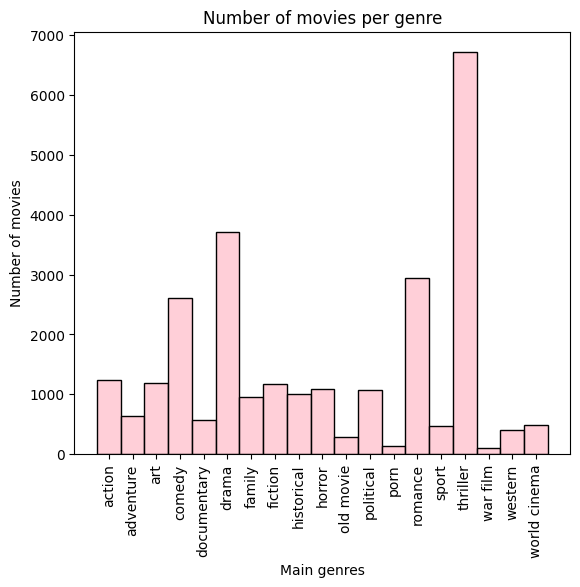

In [179]:
movie_metadata_filtered['Movie_main_genre'] = movie_metadata_filtered.Movie_main_genre.astype('category')

ax = sns.histplot(movie_metadata_filtered,x='Movie_main_genre',stat='count',color='pink')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.gcf().subplots_adjust(bottom=0)
ax.set(xlabel="Main genres",ylabel="Number of movies",title="Number of movies per genre")



In [180]:
movie_metadata_filtered.drop(labels=["Movie_genres","Movie_languages","Movie_main_language"],axis=1,inplace=True)
movie_metadata_filtered.to_csv("Data/Movie_metadata_filtered.csv")

# Processing character metadata 

We may want to look at character names as it may be part of the title of the movie (Batman in Batman movies for example). To do this we add here the character names in the movie_metadata_database ('movie_metadata_filtered'). And we later add a column for wether a character name is in the title or not.

In [181]:
#Drop row without character names
movie_characters = movie_metadata_filtered.copy(deep=True)

character_metadata_copy = character_metadata.copy(deep=True)
character_metadata_copy.dropna(subset=['Character_name'], inplace=True)

character_metadata_copy.drop(labels=["Movie_release_date","Freebase_movie_ID"],axis=1,inplace=True)

movie_characters=movie_characters.merge(character_metadata_copy, how='inner',left_on='Wikipedia_movie_ID', right_on='Wikipedia_movie_ID')

movie_characters = movie_characters[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date',  'Movie_box_office_revenue', 'Movie_runtime', 'Movie_countries', 'Movie_main_genre', 'Character_name', 'Freebase_character_ID']]


movie_characters = movie_characters.groupby('Wikipedia_movie_ID').agg({
    'Movie_name': 'first',  
    'Movie_box_office_revenue': 'first', 
    'Movie_runtime': 'first',  
    'Movie_countries': 'first',  
    'Movie_main_genre': 'first',  
    'Character_name': lambda x: list(x),  
    'Freebase_character_ID':  lambda x: list(x)
}).reset_index()
movie_characters.sample(5).head()

,Wikipedia_movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_countries,Movie_main_genre,Character_name,Freebase_character_ID
3099,1742101,Titanic,NaN,173.0,"[United States of America, Canada]",fiction,"[Isabella Paradine, Simon Doonan, Molly Brown]","[/m/0gxrpd9, /m/0gzfljb, /m/02nwr44]"
13151,21372616,Mandalay,NaN,65.0,[United States of America],thriller,[Betty Shaw],[/m/0gy78zj]
9276,9590609,While She Was Out,NaN,88.0,"[United States of America, Canada, Germany]",thriller,[Chuckie],[/m/0h33shm]
4124,2476100,An American Tail: The Treasure of Manhattan Is...,NaN,80.0,[United States of America],adventure,"[Toplofty, Cholena, Tiger, Papa Mousekewitz, P...","[/m/0bc4300, /m/0bc35w6, /m/0669rl_, /m/0669sc..."
12025,17776753,Spirit of the Forest,NaN,90.0,[Spain],family,"[Oak, Cebolo, Mrs. D'Abondo, Furi]","[/m/0h1jlsx, /m/0h32qcn, /m/0h2d1k9, /m/0h2j_pc]"


In [182]:
movie_characters['Character_name'].size

16471

In [183]:
# Check if one of the character's name is present in the movie title
def is_in_title(df):
    characters = df['Character_name']
    title = str(df['Movie_name'])
    for i in characters:
        if str(i) in title:
            return True
        return False

movie_characters['Character_in_title'] = movie_characters.apply(lambda x: is_in_title(x), axis=1)
movie_with_character_in_title = movie_characters['Character_in_title'].sum()

print(f"Fraction of movie titles containing character name: {movie_with_character_in_title / len(movie_characters):.2%}")
print(movie_characters.loc[movie_characters['Character_in_title'] == 1, ['Movie_name', 'Character_name']])

Fraction of movie titles containing character name: 2.94%
                               Movie_name  \
3                                  Batman   
6                          Batman Forever   
43                         The Terminator   
52                               THX 1138   
81                 The Life of Emile Zola   
...                                   ...   
16270           The Elizabeth Smart Story   
16380               Margaret Bourke-White   
16410  Captain America II: Death Too Soon   
16430                      Up Goes Maisie   
16463     Rita Hayworth: The Love Goddess   

                                          Character_name  
3      [Batman, Catwoman, Joker, Penguin, Riddler, Al...  
6      [Batman, Harvey Dent, Dr. Chase Meridian, Suga...  
43     [Terminator, Kyle Reese, Sarah Connor, Punk Le...  
52     [THX, SEN, SRT, LUH, PTO, TWA, NCH, DWY, IMM, ...  
81                                          [Emile Zola]  
...                                            

In [184]:
movie_characters.drop(labels=["Movie_name","Movie_box_office_revenue","Movie_runtime","Movie_countries","Movie_main_genre","Freebase_character_ID"],axis=1,inplace=True)

movie_metadata_filtered = movie_metadata_filtered.merge(movie_characters,how='left', on = 'Wikipedia_movie_ID')
movie_metadata_filtered.to_csv("Data/movies_preprocessed.csv")
